In [1]:
import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model, dummy_loss
from generator_busboat import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
import keras
from keras.models import load_model

Using TensorFlow backend.
/home/henri_tomas/miniconda3/envs/keras1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henri_tomas/miniconda3/envs/keras1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henri_tomas/miniconda3/envs/keras1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

#Foreign Object Transplant as Data augmentation for Object Detection Networks


*   Inspired by mixup data augmentation, which linearly blends two images to solve the elephant-in-the-room problem: altering contextual information in a frame worsens object detection recall. 
*   Key idea: Randomly transplanting foreign, out-of-context objects into training images as a form of nonlinear data augmentation should help against similar adversarial attacks and noise. 

In [2]:
def create_training_instances(
    train_annot_folder,
    train_image_folder,
    train_cache,
    valid_annot_folder,
    valid_image_folder,
    valid_cache,
    labels,
):
    # parse annotations of the training set
    train_ints, train_labels = parse_voc_annotation(train_annot_folder, train_image_folder, train_cache, labels)

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(valid_annot_folder):
        valid_ints, valid_labels = parse_voc_annotation(valid_annot_folder, valid_image_folder, valid_cache, labels)
    else:
        print("valid_annot_folder not exists. Spliting the trainining set.")

        train_valid_split = int(0.8*len(train_ints))
        np.random.seed(0)
        np.random.shuffle(train_ints)
        np.random.seed()

        valid_ints = train_ints[train_valid_split:]
        train_ints = train_ints[:train_valid_split]

    # compare the seen labels with the given labels in config.json
    if len(labels) > 0:
        overlap_labels = set(labels).intersection(set(train_labels.keys()))

        print('Seen labels: \t'  + str(train_labels) + '\n')
        print('Given labels: \t' + str(labels))

        # return None, None, None if some given label is not in the dataset
        if len(overlap_labels) < len(labels):
            print('Some labels have no annotations! Please revise the list of labels in the config.json.')
            return None, None, None
    else:
        print('No labels are provided. Train on all seen labels.')
        print(train_labels)
        labels = train_labels.keys()

    max_box_per_image = max([len(inst['object']) for inst in (train_ints + valid_ints)])

    return train_ints, valid_ints, sorted(labels), max_box_per_image

In [3]:
!rm ./voc_train.pkl
!rm ./voc_valid.pkl

config_path='config_busboat.json'

with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

###############################
#   Parse the annotations 
###############################
train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
    config['train']['train_annot_folder'],
    config['train']['train_image_folder'],
    config['train']['cache_name'],
    config['valid']['valid_annot_folder'],
    config['valid']['valid_image_folder'],
    config['valid']['cache_name'],
    config['model']['labels']
)
print('\nTraining on: \t' + str(labels) + '\n')

###############################
#   Create the generators 
###############################    
train_generator = BatchGenerator(
    instances           = train_ints, 
    anchors             = config['model']['anchors'],   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = config['train']['batch_size'],
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],   
    shuffle             = True, 
    jitter              = 0.3, 
    norm                = normalize,
    nl_mixup            = 1.0
)

Seen labels: 	{'chair': 1432, 'car': 1644, 'horse': 406, 'person': 5447, 'bicycle': 418, 'cat': 389, 'dog': 538, 'head': 439, 'foot': 434, 'hand': 681, 'train': 328, 'aeroplane': 331, 'diningtable': 310, 'tvmonitor': 367, 'bird': 599, 'bottle': 634, 'motorbike': 390, 'pottedplant': 625, 'boat': 398, 'sofa': 425, 'sheep': 353, 'cow': 356, 'bus': 272}

Given labels: 	['bus', 'boat', 'bottle', 'chair', 'cow', 'diningtable']

Training on: 	['boat', 'bottle', 'bus', 'chair', 'cow', 'diningtable']



In [9]:
data, dummy = train_generator.__getitem__(10)

resizing:  384 384


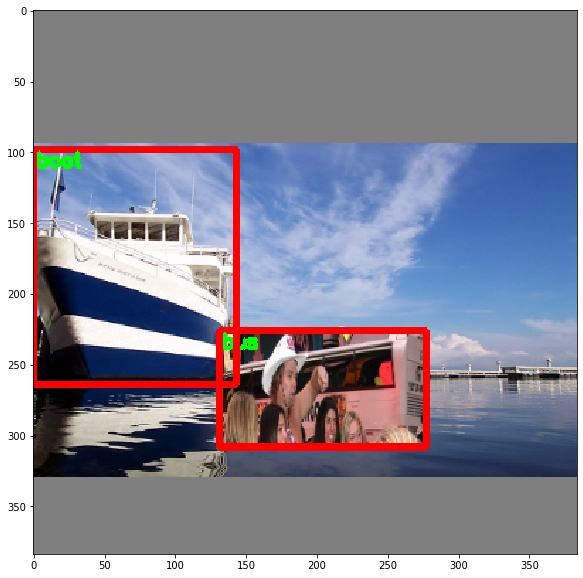

In [10]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib

plt.figure(figsize = (10,10))
plt.imshow(data[0][0], aspect='equal')
plt.show()

In [28]:
train_ints[0]['object']

[{'name': 'chair', 'xmin': 11, 'ymin': 206, 'xmax': 84, 'ymax': 333},
 {'name': 'chair', 'xmin': 92, 'ymin': 245, 'xmax': 198, 'ymax': 375}]